In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jaxley as jx

from jaxley import Compartment
from jaxley_mech.channels.tfmc90 import Phototransduction
from jaxley_mech.channels.lk04 import h, Kx, Kv, Ca, CaPump, CaNernstReversal, KCa, ClCa, Leak


In [2]:
META = {
    "cell_type": "rod",
    "species": "salamander (Ambystoma tigrinum)",
    "reference": [
        "Torre, V., Forti, S., Menini, A., & Campani, M. (1990). Model of Phototransduction in Retinal Rods. Cold Spring Harbor Symposia on Quantitative Biology, 55(0), 563–573. https://doi.org/10.1101/SQB.1990.055.01.054",
        "Kamiyama, Y., Wu, S. M., & Usui, S. (2009). Simulation analysis of bandpass filtering properties of a rod photoreceptor network. Vision Research, 49(9), 970–978. https://doi.org/10.1016/j.visres.2009.03.003",
    ],
    "note": "The model is from Torre et al. (1990) but variable naming convention and default parameters are from Kamiyama et al. (2009).",
}

def parse_s(s, to_records=[]):
    # if len(s) !== len(t):
    return {key: s[i].T[:-1] for (i, key) in enumerate(to_records)}


Here, we reproduced TEA-induced oscillatory action potentials in rods under "dark" current conditions, which were disrupted by two 20 ms light pulses over 30 seconds (Liu & Kourennyi, 2006). Unlike the Liu paper, which used precomputed photocurrent, we simulated the photocurrent via the phototransduction channel (Torre, et al., 1990).

NameError: name 'itensity' is not defined

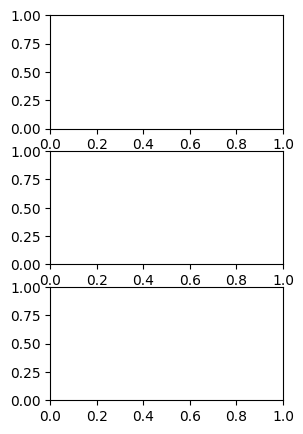

In [5]:


params = {
    "length": 10,
    "radius": 5,
    "capacitance": 30.0,
    "axial_resistivity": 34.5,
    "v": -34,

    "Leak_gLeak": 0.52e-3,
    "Leak_eLeak": -74,

    "eK": -74,
    "Kv_gKv": 1e-3,
    "Kx_gKx": 0.45e-3,

    "CaPump_depth": 10,
    "CaPump_taur": 20, 
    "CaPump_cainf": 5e-5,    

    "ClCa_eClCa": -20,
    "ClCa_gClCa": 1.3e-3,
    "ClCa_Khalf": 1e-3, 

    "KCa_gKCa": 0.2e-3,
    "KCa_Khalf": 0.32e-3,

    "Ca_gCa": 2.2e-3, 
    "eCa": 40,
    
    "h_gh": 2.5e-3,
    "h_eh": -32,
}

to_records = [
    "iPhoto", # photocurrent in outer segment
    "v", # photoresponse in inner segment
] # albeit we model it in a single compartment


fig, ax = plt.subplot_mosaic([["Jhv"], ["Photocurrent"], ["v"]], figsize=(3, 5))

for intensity in [200]:
    pre_light_time_1 = 1000  # ms
    pre_light_time_2 = 15000 # ms
    light_on_time = 20  # ms
    total_time = 30000 # ms
    dt = 0.1 # ms
    time_steps = int(total_time / dt)
    time = jnp.linspace(0, total_time, time_steps)

    cell = Compartment()
    cell.insert(Phototransduction())
    cell.insert(h())
    cell.insert(Kx())
    cell.insert(Kv())
    cell.insert(Ca())
    cell.insert(ClCa())
    cell.insert(KCa())
    cell.insert(CaPump())
    cell.insert(CaNernstReversal())
    cell.insert(Leak())

    for name, param in params.items():
        cell.set(name, param)
    
    cell.init_states()
    
    Jhv = jnp.zeros(time_steps)
    light_on_start_1 = int(pre_light_time_1 / dt)
    light_on_end_1 = int((pre_light_time_1 + light_on_time) / dt)


    light_on_start_2 = int( pre_light_time_2 / dt)
    light_on_end_2 = int((pre_light_time_2 + light_on_time) / dt)
    Jhv = Jhv.at[light_on_start_1:light_on_end_1].set(itensity)
    Jhv = Jhv.at[light_on_start_2:light_on_end_2].set(itensity)
    Jhv = Jhv.reshape(-1,1)


    # This utilizes an experimental feature of jaxley in the external_input branch
    cell.external_states = {
        "Phototransduction_Jhv": Jhv,    
    }

    for rec in to_records:
        cell.record(rec, verbose=False)

    # Run the simulation
    s = jx.integrate(cell, delta_t=dt, t_max=total_time)
    s = parse_s(s, to_records)

    ax["Jhv"].plot(time, Jhv, label=f"{intensity} R*/ms")
    ax["Photocurrent"].plot(time, s["iPhoto"], label=f"{intensity} R*/s")
    ax["v"].plot(time, s["v"], label=f"{intensity} R*/s")

for key in ax.keys():
    ax[key].set_xlabel("Time (ms)")

ax["Jhv"].set_title(r"$J_{hv}$")
ax["Photocurrent"].set_title(r"$I_{photo}$")
ax["v"].set_title(r"$V_{photo}$")

fig.tight_layout()

KeyError: 'Key not recognized.'

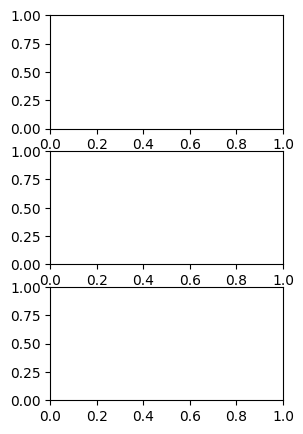

In [ ]:


params = {
    "length": 10,
    "radius": 5,
    "capacitance": 30.0,
    "axial_resistivity": 34.5,
    "v": -34,

    "Leak_gLeak": 0.52e-3,
    "Leak_eLeak": -74,

    "eK": -74,
    "Kv_gKv": 1e-3,
    "Kx_gKx": 0.45e-3,

    "CaPump_depth": 10,
    "CaPump_taur": 20, 
    "CaPump_cainf": 5e-5,    

    "ClCa_eClCa": -20,
    "ClCa_gClCa": 1.3e-3,
    "ClCa_Khalf": 1e-3, 

    "KCa_gKCa": 0.2e-3,
    "KCa_Khalf": 0.32e-3,

    "Ca_gCa": 2.2e-3, 
    "eCa": 40,
    
    "h_gh": 2.5e-3,
    "h_eh": -32,

    f"{name_photo}_alpha1": 20.0,  # /s, rate constant of Rh* inactivation
    f"{name_photo}_alpha2": 0.0005,  # /s, rate constant of the reaction Rhi -> Rh*
    f"{name_photo}_alpha3": 0.05,  # /s, rate constant of the decay of inactive rhodopsin
    f"{name_photo}_epsilon": 0.5,  # /s * /μM, rate constant of T* activation
    f"{name_photo}_T_tot": 1000.0,  # μM, total transduction
    f"{name_photo}_beta1": 10.6,  # /s, rate constant of T* inactivation
    f"{name_photo}_tau1": 0.1,  # /s * /μM, rate constant of PDE activation
    f"{name_photo}_tau2": 10.,  # /s, rate constant of PDE inactivation
    f"{name_photo}_PDE_tot": 100.0,  # μM, total phosphodiesterase
    f"{name_photo}_sigma": 1.0,  # /s * /μM, proportionality constant
    f"{name_photo}_gamma_Ca": 50.0,  # /s, rate constant of Ca2+ extrusion in the absence of Ca2+ buffers mediated by the Na+/Ca2+ exchanger
    f"{name_photo}_C0": 0.1,  # μM, intracellular Ca2+ concentration at the steady state
    f"{name_photo}_b": 0.625,  # μM / s * /pA,proportionality constant between Ca2+ influx and photocurrent
    f"{name_photo}_k1": 0.2,  # /s * /μM, on rate constants for binding of Ca2+ to the buffer
    f"{name_photo}_k2": 0.8,  # /s, off rate constants for binding of Ca2+ to the buffer
    f"{name_photo}_eT": 500,  # μM, low affinity Ca2+ buffer concentration
    f"{name_photo}_V_max": 0.4,  # /s, cGMP hydrolysis in dark
    f"{name_photo}_A_max": 65.6,  # μM/s, guanylate cyclase activity
    f"{name_photo}_K_c": 0.1,  # nM, intracellular Ca2+ concentration halving the cyclase activity
    f"{name_photo}_J_max": 5040.0,  # pA, maximal cGMP-gated current in excised patches

}

to_records = [
    "iPhoto", # photocurrent in outer segment
    "v", # photoresponse in inner segment
] # albeit we model it in a single compartment


fig, ax = plt.subplot_mosaic([["Jhv"], ["Photocurrent"], ["v"]], figsize=(3, 5))

for itensity in [200]:
    pre_light_time_1 = 1000  # ms
    pre_light_time_2 = 1000 # ms
    light_on_time = 20  # ms
    total_time = 5000 # ms
    dt = 0.1 # ms
    time_steps = int(total_time / dt)
    time = jnp.linspace(0, total_time, time_steps)

    cell = Compartment()
    cell.insert(Phototransduction())
    cell.insert(h())
    cell.insert(Kx())
    cell.insert(Kv())
    cell.insert(Ca())
    cell.insert(ClCa())
    cell.insert(KCa())
    cell.insert(CaPump())
    cell.insert(CaNernstReversal())
    cell.insert(Leak())

    for name, param in params.items():
        cell.set(name, param)
    
    cell.init_states()
    
    Jhv = jnp.zeros(time_steps)
    light_on_start_1 = int(pre_light_time_1 / dt)
    light_on_end_1 = int((pre_light_time_1 + light_on_time) / dt)


    light_on_start_2 = int( pre_light_time_2 / dt)
    light_on_end_2 = int((pre_light_time_2 + light_on_time) / dt)
    Jhv = Jhv.at[light_on_start_1:light_on_end_1].set(itensity)
    Jhv = Jhv.at[light_on_start_2:light_on_end_2].set(itensity)
    Jhv = Jhv.reshape(-1,1)


    # This utilizes an experimental feature of jaxley in the external_input branch
    cell.external_states = {
        "Phototransduction_Jhv": Jhv,    
    }

    for rec in to_records:
        cell.record(rec, verbose=False)

    # Run the simulation
    s = jx.integrate(cell, delta_t=dt, t_max=total_time)
    s = parse_s(s, to_records)

    ax["Jhv"].plot(time, Jhv, label=f"{itensity} R*/ms")
    ax["Photocurrent"].plot(time, s["iPhoto"], label=f"{itensity} R*/s")
    ax["v"].plot(time, s["v"], label=f"{itensity} R*/s")

for key in ax.keys():
    ax[key].set_xlabel("Time (ms)")

ax["Jhv"].set_title(r"$J_{hv}$")
ax["Photocurrent"].set_title(r"$I_{photo}$")
ax["v"].set_title(r"$V_{photo}$")

fig.tight_layout()

In [ ]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p jaxley_mech

Last updated: 2024-06-07 20:03:07CEST

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.21.0

jaxley_mech: 0.0.1

matplotlib: 3.8.3
jaxley    : 0.0.0
jax       : 0.4.26

Watermark: 2.4.3



In [26]:
2 * 2 * 2 * 2

16

In [27]:
2 ** 4

16

In [30]:
jnp.sqrt(jnp.sqrt(0.3824))

Array(0.7863746, dtype=float32, weak_type=True)